# **VLabs Data Challenge - Prevendo o LTV de clientes do Varejo**

**Time:** Anunciação Saldanha

**Competidores:** Antonio Carlos da Anunciação e Araceli Marcia Saldanha

# LTV

As empresas precisam identificar quais são os seus principais clientes e manter o relacionamento com eles para garantir uma receita contínua. Para manter um relacionamento de longo prazo com os clientes, as empresas precisam programar esquemas de fidelidade, como descontos, ofertas, cupons, pontos de bônus e presentes.

Focar em um novo cliente é mais caro do que reter os clientes existentes, porque não é preciso gastar recursos, tempo e trabalhar duro para adquirir novos clientes. Apenas tem que manter os clientes existentes satisfeitos. O analista de negócios calcula com precisão o custo de aquisição do cliente usando CLTV (Customer Lifetime Value). CLTV indica a receita total do cliente durante todo o relacionamento. A CLTV ajuda as empresas a se concentrarem nos clientes em potencial que podem gerar mais receita no futuro.

**Objetivo:** A equipe deve prever o LTV (Lifetime Value) de cada cliente para período de 90 dias, a partir do dia 25/02/2021 até o dia 26/05/2021. Ou seja, qual o valor total gasto por esse cliente durante todo o período indicado.

---

In [1]:
#Bibliotecas necessárias
import pandas as pd
import datetime
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error

tqdm.pandas()
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

C:\Users\arace\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Análise Exploratória do Dataset

Inicialmente iremos ler a base e filtrá-la para ficar apenas com os dados dos clientes que devem ser submetidos. 

In [2]:
df = pd.read_csv('data/sales_20_21_train.csv')
submissao = pd.read_csv("data/sample_submission.csv")
df = df[df.ID_CLIENTE.isin(submissao.ID_CLIENTE.tolist())]
df.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
0,1176550,2020-01-02,37,1,9.50,337763,FIS
1,11683461,2020-01-02,15,1,6.64,195687,FIS
2,3326484,2020-01-02,29,5,446.87,56059,FIS
3,7317475,2020-01-02,18,1,6.13,297533,FIS
4,4366938,2020-01-02,23,1,13.17,181284,FIS


O dataset a ser trabalhado conta com as seguintes colunas:

* ID_VENDA - Id único para cada registro
* DT_VENDA - Data da venda
* LOJA - Id único da loja em que a venda foi realizada
* QTD_SKU - Quantidade de produtos vendidos
* VALOR - Valor total da venda
* ID_CLIENTE - Id único do cliente
* CANAL - Canal de venda (FIS - Físico, ECM - E-commerce, TELEVENDAS - Telefone, WHATSAPP - WhatsApp, IFOOD - iFood)

A seguir iremos eliminar dados nulos ou duplicados caso existam. 

In [3]:
df = df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1330120 entries, 0 to 1630611
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ID_VENDA    1330120 non-null  int64  
 1   DT_VENDA    1330120 non-null  object 
 2   LOJA        1330120 non-null  int64  
 3   QTD_SKU     1330120 non-null  int64  
 4   VALOR       1330120 non-null  float64
 5   ID_CLIENTE  1330120 non-null  int64  
 6   CANAL       1330120 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 81.2+ MB


Podemos ver que a base possui 1330120 dados não nulos e que a coluna `DT_VENDA` não está com o tipo datetime. Logo, faremos esse ajuste na célula seguinte.

In [4]:
#Converte a data que está como object para datetime e ordena pela data
df['DT_VENDA'] = pd.to_datetime(df['DT_VENDA'])
df = df.sort_values(by = 'DT_VENDA')

Em sequência buscaremos responder a algumas perguntas:

* Qual é o canal mais procurado?
* Quais são os 10 clientes que mais compram?
* Quais são os 10 clientes que mais geram receita?
* Qual o mês teve a maior receita?
* Qual o mês teve mais vendas?
* Qual loja vendeu mais?

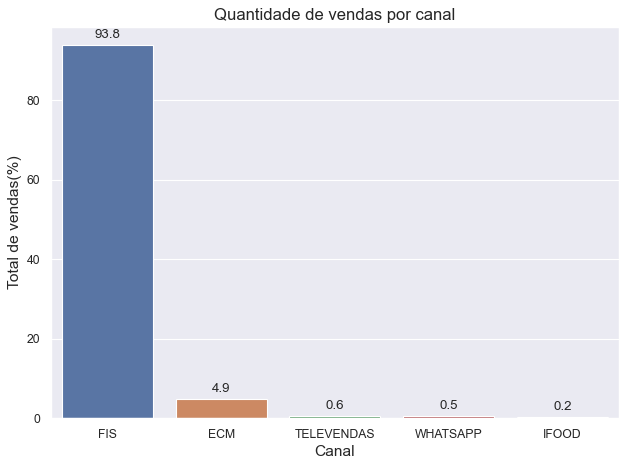

In [5]:
vendas_canal = df.CANAL.value_counts().reset_index()
#criando uma figure, axes
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
#criando o gráfico de barras 
plot = sns.barplot(x=vendas_canal['index'], y=100*vendas_canal['CANAL']/df.CANAL.value_counts().sum(), ax=ax, data=vendas_canal)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
#adicionando título
ax.set_title("Quantidade de vendas por canal", fontdict={'fontsize':15})
#mudando nome e tamanho do label x
ax.set_xlabel('Canal', fontdict={'fontsize':14})
#mudando nome e tamanho do label y
ax.set_ylabel('Total de vendas(%)', fontdict={'fontsize':14})
#otimizar espaço da figure
fig.tight_layout();

Podemos inferir que o canal mais utilizado pelos clientes é o físico, seguido pelo e-commerce e televendas. Essa informação é muito interessante, pois sabendo as preferências de canal do cliente é possível elaborar uma estratégia de marketing focada para aquele canal a fim de tentar engajar ainda mais os clientes. 

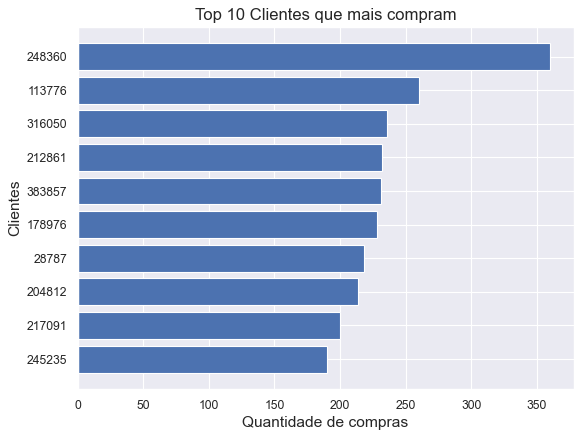

In [6]:
top10_clientes = df.ID_CLIENTE.value_counts().reset_index()[:10]
top10_clientes = top10_clientes.sort_values(by = 'ID_CLIENTE', ascending = True)
# creating the bar plot
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(top10_clientes['index'].astype(str), top10_clientes['ID_CLIENTE'])
plt.title("Top 10 Clientes que mais compram", fontsize = 15)
plt.xlabel('Quantidade de compras', fontsize = 14);
plt.ylabel('Clientes', fontsize = 14);

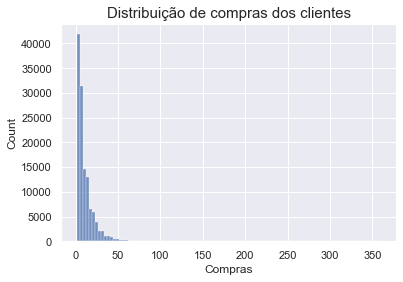

In [7]:
compras_clientes = df.ID_CLIENTE.value_counts().reset_index()
compras_clientes.rename(columns = {'ID_CLIENTE': 'Compras'}, inplace=True)
sns.histplot(data = compras_clientes,x = 'Compras', bins = 100).set_title('Distribuição de compras dos clientes', fontsize = 15);

In [8]:
print("Quantidade de clientes que possuem apenas um registro de compra: ", compras_clientes[compras_clientes.Compras == 1].shape[0])

Quantidade de clientes que possuem apenas um registro de compra:  8839


A partir do gráfico "Distribuição de compras dos clientes" e do valor impresso acima, vemos que uma quantidade expressiva de clientes realizou apenas uma compra durante todo o período analisado. Isso traz uma imprevisibilidade sobre a previsão de valor gasto para os próximos 90 dias para esses clientes, pois essas compras podem ter sido referentes a algum evento esporádico como presentear alguém, reposição de algum móvel, etc.  

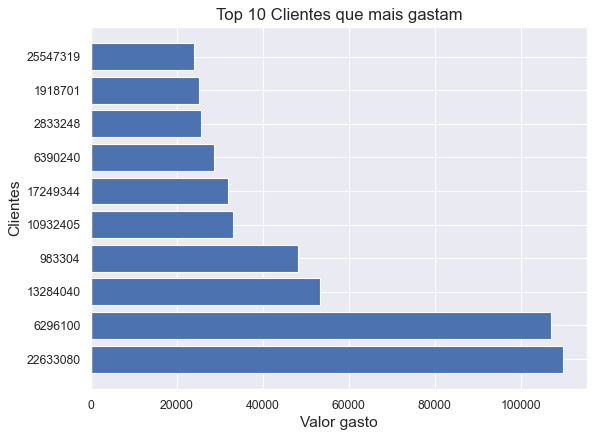

In [9]:
cliente_gastos = df.groupby(['ID_CLIENTE'])['ID_CLIENTE', 'VALOR'].sum().reset_index(drop=True)
cliente_gastos = cliente_gastos.sort_values(by = 'VALOR', ascending = False)[:10]
# creating the bar plot
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(cliente_gastos['ID_CLIENTE'].astype(str), cliente_gastos['VALOR'])
plt.title("Top 10 Clientes que mais gastam", fontsize = 15)
plt.xlabel('Valor gasto', fontsize = 14);
plt.ylabel('Clientes', fontsize = 14);

É interessante observar que não necessariamente os clientes que mais compram são os que geram mais receita.

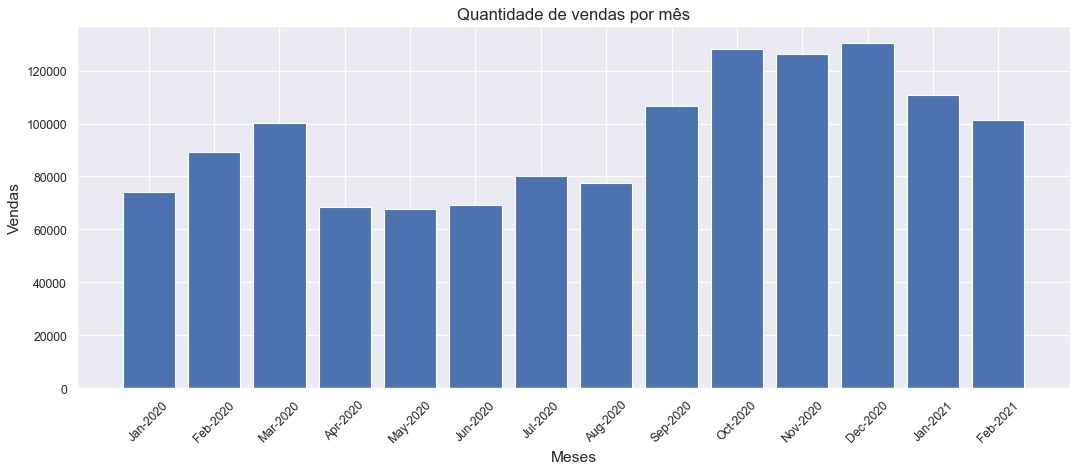

In [10]:
mes_vendas = df.copy()
mes_vendas['month_yr'] = mes_vendas['DT_VENDA'].apply(lambda x: x.strftime('%b-%Y'))
mes_vendas = mes_vendas.month_yr.value_counts().reset_index()
mes_vendas['index'] = pd.to_datetime(mes_vendas['index'])
mes_vendas = mes_vendas.sort_values(by = 'index')
mes_vendas['index'] = mes_vendas['index'].apply(lambda x: x.strftime('%b-%Y'))

plt.figure(figsize=(16, 6), dpi=80)
plt.bar(mes_vendas['index'], mes_vendas['month_yr'])
plt.xticks(rotation = 45)
plt.title('Quantidade de vendas por mês', fontsize = 15)
plt.xlabel('Meses', fontsize = 14);
plt.ylabel('Vendas', fontsize = 14);

Os meses que tiveram uma quantidade maior de vendas foram Dezembro/2020 como já era de se esperar devido as festividades de Natal e Ano Novo seguido por Outubro/2020, Novembro/2020, etc.

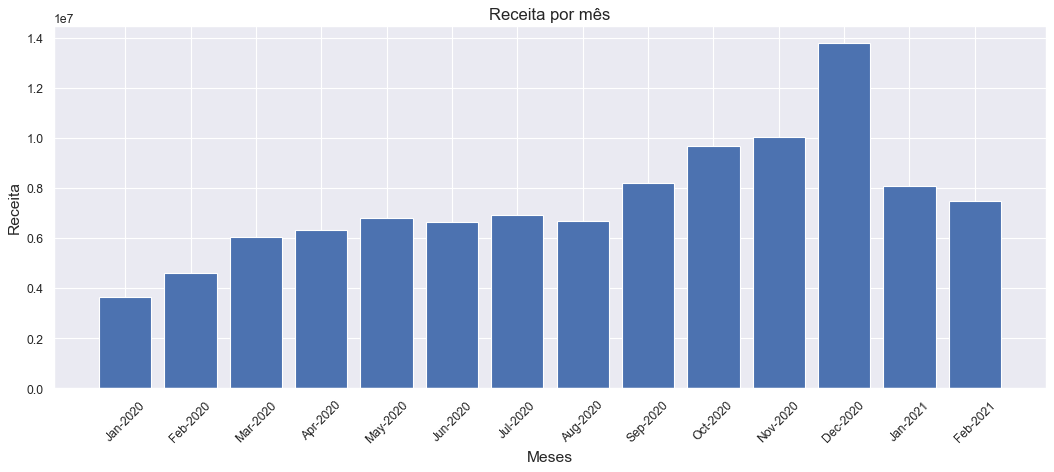

In [11]:
mes_receita = df.copy()
mes_receita['month_yr'] = mes_receita['DT_VENDA'].apply(lambda x: x.strftime('%b-%Y'))
mes_receita = mes_receita[['month_yr', 'VALOR']].groupby(['month_yr']).agg('sum').reset_index()
mes_receita['month_yr'] = pd.to_datetime(mes_receita['month_yr'])
mes_receita = mes_receita.sort_values(by = 'month_yr')
mes_receita['month_yr'] = mes_receita['month_yr'].apply(lambda x: x.strftime('%b-%Y'))

plt.figure(figsize=(16, 6), dpi=80)
plt.bar(mes_receita['month_yr'], mes_receita['VALOR'])
plt.xticks(rotation = 45)
plt.title('Receita por mês', fontsize = 15)
plt.xlabel('Meses', fontsize = 14);
plt.ylabel('Receita', fontsize = 14);

Os meses de maior receita foram Dezembro/2020, seguido de Novembro/2020, Outubro/2020, etc.

É interessante observar que provavelmente existe uma tendência de aumento das vendas anuais, isso pode ser percebido comparando as quantidades de vendas e receitas dos meses de janeiro e fevereiro de 2020 e 2021, respectivamente. Em respeito a sazonalidade anual do comportamento das vendas mensais é dificil tirar algum tipo de conclusão, pode-se argumentar que existe uma tendência de queda nas vendas pós periodo natalino, porém não há o que extrair sobre o padrão dessa queda, porque conforme indicado nos gráficos de janeiro para fevereiro de 2020 as vendas aumentaram, já para a mesma transição de meses em 2021 as vendas diminuiram.

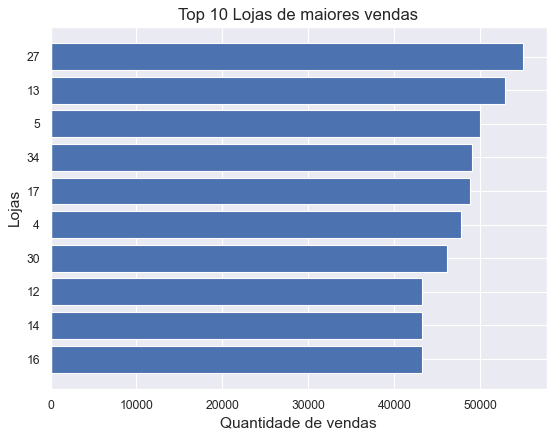

In [12]:
top10_lojas = df.LOJA.value_counts().reset_index()[:10]
top10_lojas = top10_lojas.sort_values(by = 'LOJA', ascending = True)
# creating the bar plot
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(top10_lojas['index'].astype(str), top10_lojas['LOJA'])
plt.title("Top 10 Lojas de maiores vendas", fontsize = 15)
plt.xlabel('Quantidade de vendas', fontsize = 14);
plt.ylabel('Lojas', fontsize = 14);

A loja 27 foi a que mais teve vendas, seguida por 13, 5, etc.

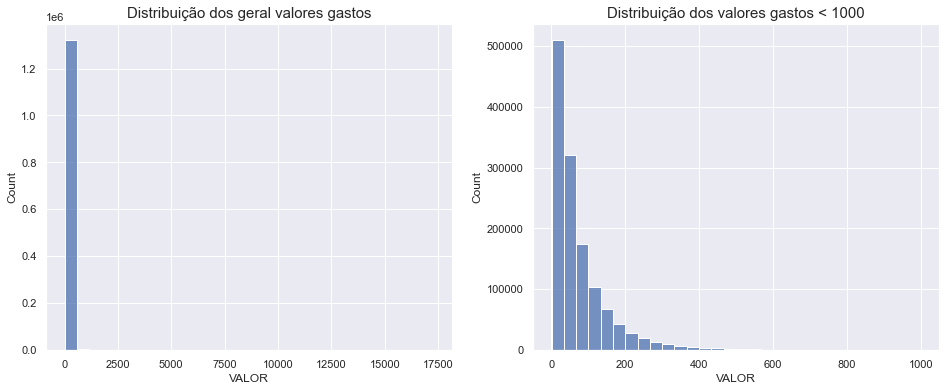

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data = df, x = 'VALOR', bins = 30, ax=axs[0]).set_title('Distribuição dos geral valores gastos', fontsize = 15);
sns.histplot(data = df[df.VALOR < 1000], x = 'VALOR', bins = 30, ax=axs[1]).set_title('Distribuição dos valores gastos < 1000', fontsize = 15);
plt.show()

A partir do gráfico acima, infere-se que a maioria das vendas está concentrada em valores abaixo de 600,00 sendo muito pouco a quantidade de vendas com valores acima de 1000,00.

# Previsão do LTV

Para fins de resolução da questão, como temos de prever os valores gastos pelos clientes para um período de 90 dias, optamos por acrescentar uma coluna no dataset informando qual período é referente aquela venda levando em consideração períodos de 90 dias, deste modo esperamos minimizar os erros de inferência, visto que se considerassemos períodos quinzenais, mensais, etc. teriamos de fazer mais inferências. Além disso, ao longo dos testes a medida que fomos aumentando o período de análise, os resultados colaboraram com nossa premissa. 

In [14]:
periodos = pd.DataFrame(pd.date_range('2021-02-25', freq='-91d', periods=6)).sort_values(by=0)[0].values
j = 1
df = df.sort_values(by='DT_VENDA')
df['TRIMESTRE'] = np.nan
df = df.reset_index(drop=True)
for i in range(0,periodos.shape[0]-1):
    indices = df[(df.DT_VENDA>=periodos[i])&(df.DT_VENDA<periodos[i+1])].index.tolist()
    df['TRIMESTRE'][indices] = j
    j+=1
    
data = df.copy()    
data = data.dropna()
data.sample(5)

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL,TRIMESTRE
520835,5820811,2020-07-20,23,3,20.69,90288,FIS,3.0
13912,10294843,2020-01-07,11,17,92.30,175481,FIS,1.0
178756,6156441,2020-03-04,16,4,48.99,48270,FIS,2.0
944598,4150623,2020-11-19,35,3,38.11,188528,FIS,4.0
234942,10815420,2020-03-18,11,1,2.20,123608,FIS,2.0


Agora vamos obter o valor gasto por cada cliente para cada período.

In [15]:
data_valor = data.pivot_table(index=['ID_CLIENTE'],columns=['TRIMESTRE'],values='VALOR',aggfunc='sum',fill_value=0).reset_index()
data_valor.sample(5)

TRIMESTRE,ID_CLIENTE,1.0,2.0,3.0,4.0,5.0
111085,341418,11.18,0.00,333.20,234.12,14.02
21419,61715,30.74,0.00,33.78,67.23,1.18
70349,216291,581.35,428.46,901.01,158.26,133.93
17548,50046,148.79,202.24,264.97,510.31,109.09
10155,28968,0.00,588.59,745.82,127.92,953.54


A seguir serão detalhadas as funções utilizadas para a obtenção dos resultados.

A função `input_data`recebe a série referente ao cliente e um valor de tamanho de janela. A partir do deslizamento dessa janela são obtidos os valores de entrada e saída para o treinamento do modelo de regressão. O exemplo abaixo ilustra os dados de entrada para o modelo obtidos para um cliente, considerando uma janela de tamanho 3. 

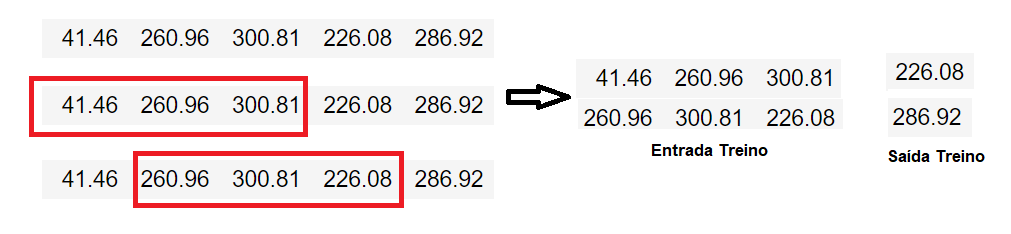

In [16]:
# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    seq = seq.tolist()
    X = []
    Y = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        X.append(window)
        Y.append(label)
    return np.array(X), np.array(Y)

A função `define_modelo`como o nome já diz é responsável por escolher qual o melhor modelo para determinado cliente. Para tanto, serão testados os modelos `KNN`e `SVM`e o escolhido será aquele que obtiver o menor `RMSE` na etapa de treinamento. 

In [17]:
def define_modelo(X_train,Y_train):
    
    model_svm = LinearSVR()
    model_svm.fit(X_train,Y_train)
    y_svm = model_svm.predict(X_train)
    rmse_svm = mean_squared_error(Y_train, y_svm, squared = False)
    
    model_knn = KNeighborsRegressor(n_neighbors=2)
    model_knn.fit(X_train,Y_train)
    y_knn = model_knn.predict(X_train)
    rmse_knn = mean_squared_error(Y_train, y_knn, squared = False)
    
    if(rmse_svm >= rmse_knn):
        return model_svm  
    else:
        return model_knn

A função `regressor`é a principal. Ela recebe a série de cada cliente, transforma/padroniza os valores gastos para cada período em um range de -1 a 1. Obtém os dados de entrada para o modelo através da utilização de uma técnica de deslizamento de janela, após isso define qual o modelo que melhor performou para aquele cliente e realiza a previsão para os próximos 90 dias. 

In [18]:
def regressor(X):
    
    # Instantiate a scaler with a feature range from -1 to 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Normalize the training set
    train_norm = scaler.fit_transform(X.values.reshape(-1, 1))
    
    # Define a window size
    window_size = 3

    # Apply the input_data function to train_norm
    X_train,Y_train = input_data(train_norm,window_size)
    
    nsamples, nx, ny = X_train.shape
    X_train = X_train.reshape((nsamples,nx*ny))
    
    nsamples, nx, ny = Y_train.shape
    Y_train = Y_train.reshape((nsamples,nx*ny))
    
    model = define_modelo(X_train,Y_train)
    
    future = 1
    preds = train_norm[-window_size:].tolist()

    for i in range(future):  
        seq = np.array(preds[-window_size:])
        seq = seq.reshape(1,-1)
        preds.append(model.predict(seq))

    # Inverse-normalize the prediction set
    predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    target = predictions[window_size:].sum()
    return target

Obtém a previsão de valor gasto para cada cliente no período de 90 dias

In [19]:
%%time

X = data_valor.iloc[:,1:6]
X['target'] = X.progress_apply(regressor, axis = 1)


Wall time: 3min 33s


Salva os resultados obtidos, relacionando o `ID_CLIENTE`com o `VALOR` gasto por ele na previsão.

In [20]:
resultado = pd.DataFrame({'ID_CLIENTE': data_valor['ID_CLIENTE'], 'VALOR': X['target']})
resultado.to_csv("resultados/resultados.csv", index=False)

In [21]:
resultado.head()

,ID_CLIENTE,VALOR
0,4,376.846353
1,9,87.643147
2,12,280.139036
3,15,209.283250
4,19,146.189549


# Referências

https://www.datacamp.com/community/tutorials/customer-life-time-value

Curso da Udemy: PyTorch for Deep Learning with Python Bootcamp